**Tuning the Gradient Boosting Regressor**

The purpose of this notebook is to tune a gradient boosting regressor model for Kaggle submission using the full training dataset.

Like in the Kaggle competition, performance will be measured using Cohen's kappa.

Our target variable is sii. However, in the original data set, sii was computed from adding the twenty PCIAT variables and then grouping the total into bins. We will predict sii by first predicting PCIAT_Total, then computing sii using the "tuned" bins

In [1]:
import pandas as pd
import numpy as np

# CustomImputers includes two imputers (using KNN and interative imputing) for this dataset
# and also two functions to transform fitnessgram values into fitnessgram zones, and to round sii values
from CustomImputers import *

**Loading and Cleaning**

Our original code generated an 80/20 test/train split of the original data at the end of the Data_Cleaning notebook.

We'll re-do that work here using the full training data, starting by cleaning the original data.

In [6]:
#Load the original training data
train=pd.read_csv('train_original.csv')

# Load the accelerometer data set Accelerometer_enmo_anglez_daily_averages.csv
accel = pd.read_csv('Accelerometer_enmo_anglez_daily_averages.csv')

# Join train and accel  on the 'id' column and accel on the 'ID' column
train = train.join(accel.set_index('ID'), on='id', how='left')

# Create a new variable 'FGC-FGC_SR' that is the mean of FGC-FGC_SRL and FGC-FGC_SRR
train['FGC-FGC_SR'] = train[['FGC-FGC_SRL', 'FGC-FGC_SRR']].mean(axis=1)

# Remove the old sit & reach variables
train = train.drop(columns=['FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone'])

# Create a new variable 'FGC-FGC_SR_Zone' that is equal to 1 if any of the following are true:
# Basic_Demos-Sex==0 and FGC-FGC_SR >= 8
# Basic_Demos-Sex==1 and FGC-FGC_SR_Zone >= 9 and Basic_Demos-Age is between 5 and 10
# Basic_Demos-Sex==1 and FGC-FGC_SR_Zone >= 10 and Basic_Demos-Age is between 11 and 14
# Basic_Demos-Sex==1 and FGC-FGC_SR_Zone >= 12 and Basic_Demos-Age is at least 15

# One way to do this is to define a function that would take sex, age, and SR value as inputs and output 1 or 0
def sitreachzone(sex, age, sr):
    try:
        if np.isnan(sr):
            return np.nan
        elif sex == 0 and sr>=8:
            return 1
        elif sex == 1 and age >= 15 and sr >= 12:
            return 1
        elif sex == 1 and age >= 11 and sr >= 10:
            return 1
        elif sex == 1 and age >= 5 and sr >= 9:
            return 1
        else:
            return 0
    except:
        return np.nan

# Apply sitreachzone to create a new column using the columns Basic_Demos-Sex, Basic_Demos-Age, and FGC-FGC_SR as inputs
train['FGC-FGC_SR_Zone'] = train.apply(lambda x: sitreachzone(x['Basic_Demos-Sex'], x['Basic_Demos-Age'], x['FGC-FGC_SR']), axis=1)

# Create a new variable that is 1 when PAQA/C Total is at least 2.75/2.73, 0 if it's less than these cutoffs, and NaN if PAQA/C is NaN
train['PAQA_Zone'] = np.where(train['PAQ_A-PAQ_A_Total']>=2.75, 1, 0)
train['PAQA_Zone'] = np.where(train['PAQ_A-PAQ_A_Total'].isnull(), np.nan, train['PAQA_Zone'])

train['PAQC_Zone'] = np.where(train['PAQ_C-PAQ_C_Total']>=2.73, 1, 0)
train['PAQC_Zone'] = np.where(train['PAQ_C-PAQ_C_Total'].isnull(), np.nan, train['PAQC_Zone'])

# Create new variables that merge the three PAQA/C variables
train['PAQ_Total']=train['PAQ_C-PAQ_C_Total']
train.loc[train['PAQ_Total'].isnull(),'PAQ_Total']=train['PAQ_A-PAQ_A_Total']

train['PAQ_Season']=train['PAQ_C-Season']
train.loc[train['PAQ_Season'].isnull(),'PAQ_Season']=train['PAQ_A-Season']

train['PAQ_Zone']=train['PAQC_Zone']
train.loc[train['PAQ_Zone'].isnull(),'PAQ_Zone']=train['PAQA_Zone']

# Drop the PAQ variables we no longer need
train=train.drop(columns=['PAQ_C-PAQ_C_Total', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_A-Season', 'PAQA_Zone', 'PAQC_Zone'])

# Combine the minutes and seconds of Fitness_Endurance into a single number (total number of seconds)
train['Fitness_Endurance_Total_Time_Sec'] = train['Fitness_Endurance-Time_Mins'] * 60 + train['Fitness_Endurance-Time_Sec']

train=train.drop(columns=['Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'])

# Remove the SDS-SDS_Total_T variable from train
train=train.drop(columns=['SDS-SDS_Total_T'])

# Remove the FGC-FGC_GSND, FGC-FGC_GSND_Zone, FGC-FGC_GSD, and FGC-FGC_GSD_Zone variables
train=train.drop(columns=['FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone'])

# Create a list of numerical columns of type float. Note that these columns include the "Zone" variables which are really categorical/ordinal:
float_columns = train.select_dtypes(include=['float']).columns

# Change negative values to NaN
train[train[float_columns] < 0] = np.nan

# For each variable that starts with 'Physical-' replace any values that are 0 with NaN
for column in train.columns:
    if column.startswith('Physical-'):
        train[column] = train[column].replace(0, np.nan)

# For each column in float_columns, identify entries that are 5 standard deviations above or below the mean and replace them with NaN
for column in float_columns:
    train[column] = train[column].mask(train[column] > train[column].mean() + 5 * train[column].std())
    train[column] = train[column].mask(train[column] < train[column].mean() - 5 * train[column].std())




**Outcome-Imputing**

The original data had missing PCIAT and sii scores. We'll impute them using KNN.

Original code is in the Outcome_Imputing notebook

In [7]:
#First we'll create a list of columns that hold the PCIAT values
pciats = [col for col in train.columns if 'PCIAT' in col]
pciats.remove('PCIAT-PCIAT_Total')
pciats.remove('PCIAT-Season')

#Create a new copy of the data frame for imputation. Remove rows where all values in pciats are NaN
train_imp_KNN = train.copy()
train_imp_KNN['pciatsnotna_sum'] = train_imp_KNN[pciats].notna().sum(axis=1)
train_imp_KNN = train_imp_KNN[train_imp_KNN['pciatsnotna_sum'] != 0]
train_imp_KNN.reset_index(drop=True, inplace=True)

#Remove the pciatsnotna_sum variable
train_imp_KNN.drop(columns=['pciatsnotna_sum'], inplace=True)

#Identify the rows with at least one NaN value
train_imp_KNN['nan_rows'] = train_imp_KNN[pciats].isnull().any(axis=1)

# Create a copy of train_imp_KNN
train_imp_KNN2 = train_imp_KNN.copy()
# define imputer
Number_Neighbors=5
imputer = KNNImputer(n_neighbors=Number_Neighbors, weights='uniform', metric='nan_euclidean')

#The imputer.fit_transform function outputs a numpy array. So first I do the fitting, then convert the output back to a pandas dataframe.

imputations=imputer.fit_transform(train_imp_KNN[pciats])
df2 = pd.DataFrame(imputations, columns=pciats)

#Next take the result and insert into the original dataframe. 

train_imp_KNN[pciats]=train_imp_KNN[pciats].fillna(df2[pciats])

#Remove the nan_rows variable
train_imp_KNN.drop(columns=['nan_rows'], inplace=True)

#Recalculate the PCIAT total score.
train_imp_KNN['PCIAT-PCIAT_Total'] = train_imp_KNN[pciats].sum(axis=1)

#Now we can calculate a new sii score with the imputed values. 
bins = [0, 30, 49,79,100]
labels = [0,1,2,3]
train_imp_KNN['sii'] = pd.cut(train_imp_KNN['PCIAT-PCIAT_Total'], bins=bins, labels=labels, right=False)

train_cleaned = train_imp_KNN

**Feature Reduction**

Here we reproduce the Feature_Reduction notebook

In [8]:
# Make a list of numeric features
numeric_features = train_cleaned.select_dtypes(include=[np.number]).columns

# Remove all PCIAT component variables from numeric features
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_0').columns))
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_1').columns))
numeric_features = numeric_features.drop(list(train_cleaned.filter(regex='PCIAT-PCIAT_2').columns))

# Remove sii and PCIAT-PCIAT_Total from numeric_features
numeric_features = numeric_features.drop(['PCIAT-PCIAT_Total'])

# Remove some variables we won't need

# Remove the variables 'id', 'BIA-BIA_BMI'
train_cleaned = train_cleaned.drop(['BIA-BIA_BMI'], axis=1)

# Remove FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, and FGC-FGC_TL_Zone
train_cleaned = train_cleaned.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_TL_Zone'], axis=1)

# Remove the following variables from train: BIA-BIA_BMR, BIA-BIA_TBW, BIA-BIA_ECW, BIA-BIA_LDM, BIA-BIA_ICW, BIA-BIA_SMM, BIA-BIA_DEE, BIA-BIA_LST, and BIA-BIA_BMC
train_cleaned=train_cleaned.drop(columns=['BIA-BIA_BMR', 'BIA-BIA_TBW', 'BIA-BIA_ECW', 'BIA-BIA_LDM', 'BIA-BIA_ICW', 'BIA-BIA_SMM', 'BIA-BIA_DEE', 'BIA-BIA_LST', 'BIA-BIA_BMC'])

# Remove the Fitness_Endurance-Max_Stage variable (based on previous exploration)
train_cleaned = train_cleaned.drop(['Fitness_Endurance-Max_Stage'], axis=1)

# Remove all variables with Season in their name
train_cleaned = train_cleaned.loc[:,~train_cleaned.columns.str.contains('Season')]

**Creating Lists**

In this section, we'll create lists of predictors based on previous exploration

For the purpose of developing our model(s), we'll work with data that include the imputed outcome (PCIAT_Total and/or sii) scores AND have cleaned predictors.

In the final version of our code (which we'll submit to Kaggle), we'll work with data with cleaned predictors but won't have any access to the outcome scores.

In [9]:
#Create an initial list of predictor columns

predictors = train_cleaned.columns.tolist()
if 'id' in predictors:
    predictors.remove('id')
if 'sii' in predictors:
    predictors.remove('sii')
predictors = [x for x in predictors if 'PCIAT' not in x]
predictors = [x for x in predictors if 'Season' not in x]

# Create an augmented list that will be used for 
predictors_plus = predictors + ['PCIAT-PCIAT_Total']

# Create a list of "key features" based on work in the Feature Selection notebook
keyfeatures = ['Basic_Demos-Age',
 'Physical-Height',
 'PreInt_EduHx-computerinternet_hoursday',
 'BIA-BIA_FFM',
 'SDS-SDS_Total_Raw',
 'Physical-Weight',
 'ENMO_Avg_Active_Days_MVPA110',
 'FGC-FGC_CU']

**Tuning the Bins**

We noticed that our model struggled to predict higher output values.

When we adjusted the values for converting PCIAT scores to sii scores, we noticed an improvement in prediction when we lowered the cutpoints.

We sought to "tune" these cutpoints. However, we need to be mindful of overfitting. 

We'll look at the combination of cutpoints that maximize kappa, and then from the top 20 (or so) select the cutpoints that are closest to the original ones (as measured by euclidean distance)

In [22]:
# Load packages
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score

# We'll use the multiple linear regression with "key" features to test the cutpoints
# This model performed as good or better than most of the other (untuned) models
# Since it is quick to run, it should be a decent choice for doing this tuning

# Start by setting up the MLR pipeline
mlr_key_pipe=Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('selector', ColumnTransformer([('selector', 'passthrough', keyfeatures)], remainder="drop")),
                ('linear', LinearRegression())])

# Set the number of k-fold splits
num_splits = 5

# Set the number of different cutpoints to try
num_bincuts=15

# Set up SMOTE
siiratios = {0: 1530, 1: 765, 2:403, 3:148}
oversample = SMOTE(sampling_strategy=siiratios)

# Create an array with len(modellist) rows and len(methodlist) columns
output = np.zeros((num_bincuts, num_bincuts,num_bincuts, num_splits))

#Make a KFold object, stratified on sii=3 values
kfold= StratifiedKFold(n_splits=num_splits, shuffle=True)

## i will count the split number 
i = 0

for train_index, test_index in kfold.split(train_cleaned, train_cleaned['sii']):
    train_tt = train_cleaned.iloc[train_index]
    train_ho = train_cleaned.iloc[test_index]

    # Compute and impute
    mice = Custom_MICE_Imputer()
    train_tt = mice.fit_transform(train_tt)
    train_tt = zone_encoder(train_tt)
    train_ho = mice.fit_transform(train_ho)
    train_ho = zone_encoder(train_ho)

    #Oversample with SMOTE
    X, y = oversample.fit_resample(train_tt[predictors_plus], train_tt['sii'])

    
    # Fit the pipe and make predictions
    mlr_key_pipe.fit(train_tt[predictors], train_tt['PCIAT-PCIAT_Total'])
    pred = mlr_key_pipe.predict(train_ho[predictors])

    # Iterate through values of the three cutpoints    
    for r in range(num_bincuts):
        for s in range(num_bincuts):
            for t in range(num_bincuts):
                bins = [0, 30-r, 49-s,79-t,100]
                pred_bin_mod = np.digitize(pred, bins)-1
                # Compute kappa for the binned predictions
                kappa_sii_comp_mod = cohen_kappa_score(train_ho['sii'], pred_bin_mod, weights='quadratic')
                output[r,s,t,i]=kappa_sii_comp_mod
                
    i=i+1

# Create a new array by computing the average of the values in output along the third axis
output_avg = np.mean(output, axis=3)

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Next, we'll examine the output of the tuning

In [23]:
# Flatten the array and sort the indices in descending order
sorted_indices_flat = np.argsort(output_avg.ravel())[::-1]

#Decide how many top values you want to look at. 
n=20

# Get the flat indices of the top two values
top_flat_indices = sorted_indices_flat[:n]

# Convert the flat indices to 3D indices
top_indices = [np.unravel_index(idx, output_avg.shape) for idx in top_flat_indices]

# Retrieve the top two values
top_values = output_avg.ravel()[top_flat_indices]

print("Top values:", top_values)
print("Locations of the top values:", top_indices)

Top values: [0.45330481 0.45330481 0.45330481 0.45330481 0.45301702 0.45301702
 0.45301702 0.45301702 0.45301702 0.45301702 0.45301702 0.45301702
 0.45301702 0.45301702 0.45301702 0.4519785  0.4519785  0.4519785
 0.4519785  0.45192565]
Locations of the top values: [(np.int64(3), np.int64(11), np.int64(14)), (np.int64(3), np.int64(11), np.int64(12)), (np.int64(3), np.int64(11), np.int64(13)), (np.int64(3), np.int64(11), np.int64(11)), (np.int64(3), np.int64(11), np.int64(1)), (np.int64(3), np.int64(11), np.int64(2)), (np.int64(3), np.int64(11), np.int64(0)), (np.int64(3), np.int64(11), np.int64(5)), (np.int64(3), np.int64(11), np.int64(3)), (np.int64(3), np.int64(11), np.int64(4)), (np.int64(3), np.int64(11), np.int64(6)), (np.int64(3), np.int64(11), np.int64(10)), (np.int64(3), np.int64(11), np.int64(7)), (np.int64(3), np.int64(11), np.int64(8)), (np.int64(3), np.int64(11), np.int64(9)), (np.int64(3), np.int64(12), np.int64(11)), (np.int64(3), np.int64(12), np.int64(14)), (np.int64(3),

**Results of Cutpoint Tuning**

We ran the code above, looked at the top 20 (in terms of kappa) sets of cutpoints, and selected the combination of cutpoints that minimized the Euclidean distance to the original cutpoints. Then we repeated this two more times. The results were:

* First time: [0, 30-3, 49-6,79-8,100] = [0, 27, 43, 71, 100]
* Second time: [0, 30-3, 49-11,79-0,100] = [0, 27, 38, 79, 100]
* Third time: [0, 30-3, 49-10,79-0,100] = [0, 27, 39, 79, 100]

We'll use this third set of cutpoints.

Re-running with the full data gives us cutpoints of:
* [0, 30-3, 46-11, 79-14, 100] (top performer)
* [0, 30-3, 46-11, 79-0, 100] (not far behind)

**Hyperparameter Tuning**

The models above were run "out of the box." In the next sections, we'll try to tune a few of them (random forest, gradient boost, and logistic regression inside an ordinal classifier) to see how much we can improve their performance.

**Tuning Gradient Boosting Regressor for PCIAT**

There are lots of parameters to consider here.

We'll use some suggestions from various websites to think about a parameter grid, being mindful of the amount of time it will take to run the code.

Sources consulted:
* https://stackoverflow.com/questions/49500313/tune-parameters-in-gradient-boosting-reggression-with-cross-validation-sklearn
* https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae
* https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

Note that we have a total of ~2500 observations with PCIAT scores in the entire dataset, a very small (32) number of scores with sii=3 and a relatively small number of scores with sii=2. SMOTE could help with this, but we can't use it inside a pipe when we're trying to predict PCIAT. (We could do this tuning manually, but due to time constraints, we're going to stick with using GridSearchCV)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

param_grid = {
    'grad__learning_rate': [.07, .06, .05],
    'grad__max_depth': [2, 3, 4],
    'grad__max_features': [7, 8, 9],
    'grad__min_samples_leaf': [8, 10, 12],
    'grad__min_samples_split': [5, 6, 7],
    'grad__n_estimators': [90, 100, 110]
}

# Instantiate a gradient boosting regressor pipeline
grad_pipe = Pipeline([('mice_impute', Custom_MICE_Imputer()),
                ('add_zones', FunctionTransformer(zone_encoder)),
                ('grad', GradientBoostingRegressor())])

grid_cv_grad = GridSearchCV(grad_pipe, 
                          param_grid = param_grid, 
                          cv = 5,
                          return_train_score=True)

# We'll start by tuning on PCIAT, and can tune separately on sii
grid_cv_grad.fit(train_cleaned[predictors], train_cleaned['PCIAT-PCIAT_Total'])


/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mice_impute', Custom_MICE_Imputer()),
                                       ('add_zones',
                                        FunctionTransformer(func=<function zone_encoder at 0x30451c400>)),
                                       ('grad', GradientBoostingRegressor())]),
             param_grid={'grad__learning_rate': [0.07, 0.06, 0.05],
                         'grad__max_depth': [2, 3, 4],
                         'grad__max_features': [7, 8, 9],
                         'grad__min_samples_leaf': [8, 10, 12],
                         'grad__min_samples_split': [5, 6, 7],
                         'grad__n_estimators': [90, 100, 110]},
             return_train_score=True)

In [16]:
# Report the results
print('Best parameters:',grid_cv_grad.best_params_)
print('Best score:',grid_cv_grad.best_score_)

Best parameters: {'grad__learning_rate': 0.06, 'grad__max_depth': 3, 'grad__max_features': 7, 'grad__min_samples_leaf': 12, 'grad__min_samples_split': 6, 'grad__n_estimators': 100}
Best score: 0.3037427165842771


**Tuning Results**

First run grid:
* 'grad__learning_rate': [0.5, 0.1, 0.05],
* 'grad__max_depth': [3,5,7],
* 'grad__max_features': [10, 15, 20, 25],
* 'grad__min_samples_leaf': [5, 8, 11],
* 'grad__min_samples_split': [3, 5, 7],
* 'grad__n_estimators': [50, 100, 200]

Best parameters (first run): 
* 'grad__learning_rate': 0.05
* 'grad__max_depth': 3
* 'grad__max_features': 10
* 'grad__min_samples_leaf': 11
* 'grad__min_samples_split': 7
* 'grad__n_estimators': 100

Best score: 0.3017769170061274

Second run grid:
* 'grad__learning_rate': [.07, 0.05, .03],
* 'grad__max_depth': [3,4,5],
* 'grad__max_features': [8, 10, 12],
* 'grad__min_samples_leaf': [9, 11, 12],
* 'grad__min_samples_split': [6, 7, 8],
* 'grad__n_estimators': [75, 100, 125]

Best parameters (second run): 
* 'grad__learning_rate': 0.07
* 'grad__max_depth': 3
* 'grad__max_features': 8
* 'grad__min_samples_leaf': 9
* 'grad__min_samples_split': 6
* 'grad__n_estimators': 100

Best score: 0.3038984198234703

Third run grid:
* 'grad__learning_rate': [.07, .06, .05],
* 'grad__max_depth': [2, 3, 4],
* 'grad__max_features': [7, 8, 9],
* 'grad__min_samples_leaf': [8, 10, 12],
* 'grad__min_samples_split': [5, 6, 7],
* 'grad__n_estimators': [90, 100, 110]

Best parameters (third run)
* 'grad__learning_rate': 0.06
* 'grad__max_depth': 3
* 'grad__max_features': 7
* 'grad__min_samples_leaf': 12
* 'grad__min_samples_split': 6
* 'grad__n_estimators': 100

Best score: 0.3037427165842771

In [17]:
# Check for overfitting

print(grid_cv_grad.cv_results_.keys())
print(grid_cv_grad.cv_results_["mean_train_score"].shape)  # n_estimators: 11 values, max_depth: 4 values. Thus shape, 11*4=44
print(grid_cv_grad.cv_results_["mean_test_score"].shape)

print(grid_cv_grad.cv_results_["mean_train_score"])
print(grid_cv_grad.cv_results_["mean_test_score"])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_grad__learning_rate', 'param_grad__max_depth', 'param_grad__max_features', 'param_grad__min_samples_leaf', 'param_grad__min_samples_split', 'param_grad__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
(729,)
(729,)
[0.36065257 0.36633718 0.37240018 0.36042104 0.36688784 0.37143254
 0.36076373 0.36646685 0.37282257 0.35965407 0.36578166 0.37122696
 0.359488   0.36733387 0.37158968 0.35937306 0.36506244 0.37225901
 0.35870789 0.36475056 0.37198754 0.35797979 0.3681739  0.37125971
 0.35951592 0.36532186 0.37210959 0.36236489 0.36869789 0.37477369
 0.36028186 0.36835043 0.37501444 0.36263271 0.36846707 0.37393408
 0.3613

Best mean_train_score: [0.4216105]
Best mean_test_score: [0.30374272]


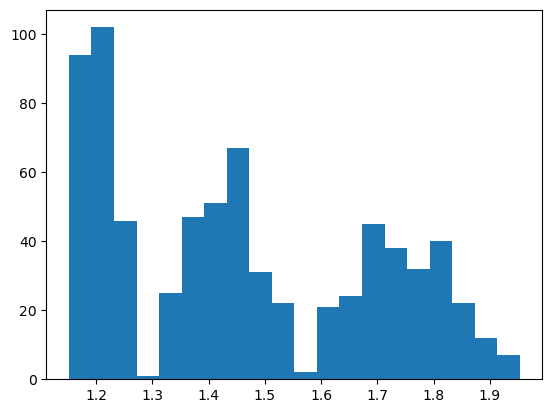

In [19]:
import matplotlib.pyplot as plt

# Identify the mean_train_score and mean_test_score values associated with best_score
best_score_index = np.where(grid_cv_grad.cv_results_["mean_test_score"]==grid_cv_grad.best_score_)
print('Best mean_train_score:', grid_cv_grad.cv_results_["mean_train_score"][best_score_index])
print('Best mean_test_score:', grid_cv_grad.cv_results_["mean_test_score"][best_score_index])

#Create a df with grid_cv_grad.cv_results_["mean_train_score"] as the first column and grid_cv_grad.cv_results_["mean_test_score"] as the second column
grad_results_df = pd.DataFrame({'mean_train_score': grid_cv_grad.cv_results_["mean_train_score"], 'mean_test_score': grid_cv_grad.cv_results_["mean_test_score"]})

# Compute a new collumn that is the ratio of mean_train_score to mean_test_score
grad_results_df['ratio'] = grad_results_df['mean_train_score']/grad_results_df['mean_test_score']

# Identify outliers in ratio
Q1 = grad_results_df['ratio'].quantile(0.25)
Q3 = grad_results_df['ratio'].quantile(0.75)
IQR = Q3 - Q1
outliers = grad_results_df[(grad_results_df['ratio'] < (Q1 - 1.5 * IQR)) | (grad_results_df['ratio'] > (Q3 + 1.5 * IQR))]

# Remove the outliers from grad_results_df
grad_results_df = grad_results_df[~grad_results_df['ratio'].isin(outliers['ratio'])]

# Create a histogram of ratio
plt.hist(grad_results_df['ratio'], bins=20)
plt.show()

**Interpretation**

The ratio of train kappas to test kappas using our "best" set of parameters was 1.4868. This seems like it might correspond to overfitting. But it seems in line with the (non-outlier) ratios among all tested sets of hyperparameters.